## Testing the Correlation between Public Accesses and Zebra Mussel Occurence

## Introduction

Zebra mussels (Dreissena polymorpha) are the most devastating of all non-indigenous aquatic species (NAS). Billions of dollars are spent annually to prevent the spread and mitigate the impacts to infrastructure and ecosystem services caused by Dreissinid mussels (Nelson et al. 2019; Pimental et al. 2005; Sepulveda et al. 2020). Zebra mussels were introduced into the Great Lakes region most likely during the 1980's via ballast discharge, and they have since shown up as far away as Texas and California. Overland transport via recreational watercraft trailered from infested lakes to new locations is a main vector for the spread of zebra (Johnson et al. 2001). 

Understanding vectors and pathways of spread are critical for predicting and preventing the expansion of NAS. However, an empirical understanding of how the number of public accesses (boat launches) on a waterbody influences the overall risk for introduction for zebra mussels is lacking. This script is designed to filter and join spatial datasets which would otherwise be too cumbersome to deal with in a desktop GIS to answer the question, "How does the number of public accesses impact the probability of the presence of zebra mussels?" 

<img src='./data/ZM_USGS_Map.png' width="600" height="800">

#### Hypothesis:
If zebra mussel presence is correlated with the level of propagule pressure, then the number of public accesses on a waterbody (boat ramps) will impact the likelihood of introduction because the number of public accesses is the mechanism driving the intensity of propagule pressure for a waterbody.

#### Null Hypothesis: 
There is no correlation between the occurence of zebra mussels and the numbers of public accesses.

#### Prediction:
Logistic regression will indicate a correlation between the occurence of zebra and the numbers of public accesses. E.g., lakes without zebra mussels with be clustered at the left with few accesses and lakes with zebra mussels will be clustered on the right of the plot with more accesses.

### Methods

#### Study Organism
Zebra mussels (Dreissena polymorpha; Pallas 1769) are native to the Ponto-Caspian and Black-Sea Drainages. These freshwater bivalves are less than 50 mm as adults and attach to hard substrate via byssal threads. Their lifecycle includes a planktonic veliger stage which promotes downstream dispersal. These invaders impact systems by attaching to available substrate, competing for planktonic resources and by biofouling particles.  They clog pipes and other infrastructure and cause huge amounts of economic damage annually.

#### Study Area
There are approximately 205,032 lakes in MN with 4144 larger than 0.50 square kms. There are 3013 public water accesses dispersed across these lakes. Minnesota has a long history of invasion by non-indigenous aquatic species including by zebra mussels in 1989. Zebra mussels now inhabit 167 MN lakes. MN is also ideal for this study because of the availability of spatial data for waterbodies, public accesses and zebra mussel occurences.

#### Data Sources
The Non-Indigenous Aquatic Species database has existed for more than 30 years and houses temporally correlated georeferenced  records for over 2,000 NAS at the national scale (Fuller P, Neilson M, 2015).  The 439 Zebra mussel records that range from 1989 to 2022 can be retrieved from https://nas.er.usgs.gov. These records are directly imported into this script via the NAS database API. Additional Species ID's can be found at https://nas.er.usgs.gov/api/v2/species.

<img src='./data/ZM_MN_Map.png' width="600" height="600">

The shapefile for MN Lake polygons was retrieved from the USGS TNM Download (v2.0; https://apps.nationalmap.gov/downloader/#/). The MN Waterbody Shapefile contains 205,032 lake polygons many of which do not have public accesses. It is reduced to lakes with an area greater than 0.50 square km and with at least 1 public access. The direct link to the zip file is provided within the readme file included with this script or download now from: https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/NHD/State/Shape/NHD_H_Minnesota_State_Shape.zip.

<img src='./data/MW_Waterbody_Map.png' width="600" height="600">

Waterbody public accesses spatial data is provided by the MN Department of Natural Resources (MNDNRC) and was retrieved as a shapefile from https://gisdata.mn.gov/dataset/loc-water-access-sites. There are 3013 public accesses in MN.

<img src='./data/ZM_Public_Accesses.png' width="600" height="600">

#### Statistical Approach

Logistic regression is used because my dependent variable, the presence/absence of zebra mussels is represented by a '1' or '0' respectively. This method of binary classification is useful for identifying non-linear relationships between a single independent variable and the dependent variable. The assumptions that must be met for a linear model are, linearity and no outliers
independence. Further, we need to make sure that we aren't combining the counts for public accesses together for lakes with the same name.  To assure our training data meets these assumptions, this script includes blocks to remove duplicate lakes and a function to identify and remove outliers before the analysis.

#### Model Accuracy
To test the accuracy of the model, the initial dataset was split into training and testing by randomly selecting 25% of the data to be held for testing.  A confusion matrix is also visualized to assess how well the model performed when predicting to the testing dataset.  

#### Hypothesis Testing
The regression plot and coefficients will be used to assess the correlation between the presence/absence of zebra mussels and the number of public accesses and the expected increase/decrease in the log odds of our outcome variable for each unit increase, respectively. The null hypothesis will be falsified if the regression plot shows that lakes with higher numbers of public accesses are 1's and those with fewer accesses are 0's.

## Technical Approach

The goal of this script is to test whether the number of public accesses on a waterbody is correlated with the presence of zebra mussels for MN. 
The waterbody (lakes) shapefile is then imported and reduced to lakes greater than 0.50 square km using the area column within the attributes. Next the public accesses shapefile is imported as a geopandas geodataframe. To improve the accuracy of spatial joins, the CRS for all geodataframes is then converted to projected reference system (3857). This script then calls to the USGS NAS Database API to get occurrence data. A series of helper functions are then used to convert the retrieved data into a geopandas geodataframe. 

The geopandas sjoin function is used to spatially the join public accesses shapefile to the lakes shapefile. The leftjoin argument is used to return rows for each ramp joined to the columns of the associated lakes. One potential pitfall to consider is there are multiple lakes with the same name.  For example, there are at least three Wolf Lakes in MN.  To avoid combining the counts for public accesses for these lakes with the same name, the right index which came along with the previous spatial join is renamed to Lake_ID. The groupby function is then applied along with the count function to get the number of public accesses by waterbody. 

We need to get a bit crafty here. All of this joining has resulted in the most recent geometry coming from the access points, but we need the lake polygons. Since the Lake_ID is equivalent to the index from the original lakes shapefile, we can set the Lake_ID as the index and merge to the original waterbody shapefile.  Now that we have lake polygons with the count for public accesses, we need to spatially join the occurence records to this geodataframe. To do so, the sjoin function with the leftjoin option is applied.  Once again, this results in duplicate records for some lakes due to the occurence data containing duplicate spatial records from different years.  Here we can simply use geopandas to remove these duplicates. We now have a geodataframe with counts for the number of public accesses by lake. 

To get the negative lakes, we create a list from the Lake_ID column for the positive lakes and use it to select the rows from the combined waterbodies and accesses count dataframe that do not match the positive Lake_ID's. Since, logistic regression can be thrown off by outliers, the standard deviation is used to identify records within the positive and negative lakes dataset where the count for ramps exceeds +- SD * 5.  5 was chosen so only extreme outliers are removed. This step also adds a '1' or a '0' based on the presence/absence of zebra mussels.

A final dataframe is then created by concatenating the positive and negative dataframes.  This final dataset is then cast to a numpy array and the sklearn train_test_split function is used to set up the data for modeling. The sklearn LogisticRegression function is then fit to the training data and the resulting model is used to predict to the testing data. The regression plot is then visualized using the Seaborn replot function. Accuracy scores are produced for the testing dataset using the sklearn score function. The sklearn confusion matrix function is then used and the Seaborn heatmap function is used to plot the results. 

Code to use the model to predict to a numpy array containing values for public accesses between 0 and 27 is also provided. A secondary goal of this script is to be flexible such that the user can ask the same question for other NAS and within other states.  Instructions for modifying the code for a different NAS taxa and state are provided within the README.md.

Run the following cells to repeat these steps and perform the analysis described within the results section below. This script follows the PEP-8 Style guidelines and was designed with the user in mind such that the code style, formatting and variable names are consistent, distinctive and meaningful per the recommendations of Wilson et al (2014). 

## Workflow Diagram

<img src='./data/workflow.png' width="600" height="800">

#### Import Packages

In [1]:
#Import required packages
import pandas as pd
import geopandas as gpd
import numpy as np
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std
import json
import requests
from functools import reduce
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

C:\OSGeo4W\apps\Python39\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


#### User Defined Variables and Data Imports

In [2]:
# Define Species ID and State
species_id = 5
my_state = 'Minnesota'

In [3]:
## Import waterbody shapefile, Get lakes larger than .5 km squared, change to projected crs and slice to just the lake name and geometry
MN_lakes = gpd.read_file('./data/Shape/NHDWaterbody.shp')
lake_mask = MN_lakes['areasqkm'] > .5
lakes_filtered = MN_lakes.loc[lake_mask].to_crs(3857)
lakes_gpd = lakes_filtered[['gnis_name', 'geometry']]

In [4]:
## Import Public Accesses shapefile, change to projected crs and slice to just the facility name and geometry
access_df = gpd.read_file('./data/MN_accesses.shp')
access_df_crs = access_df.to_crs(3857)
my_accesses = access_df_crs[['FAC_NAME', 'geometry']]

#### Helper Functions for Accessing and Formatting NAS data

In [5]:
## Helper Functions to convert USGS NAS Records into geodataframe.
def _get_col_rename(df, dftype):
    """Returns a dictionary of columns to rename based on the dataframe and type('csv' or 'api')"""
    
    # Build a dictionary of column renamings for use in pandas rename function
    renamed_columns = {}
    column_names = list(df.columns)
    lower_columns = [name.lower().replace(' ','').replace('_','') for name in column_names]
    for i in range(len(column_names)):
        renamed_columns[column_names[i]] = lower_columns[i]

    if dftype == 'csv':
        # build csv rename dictionary
        renamed_columns['museumcatno'] = 'museumcatnumber'
        renamed_columns['huc8number']  = 'huc8'
    elif dftype == 'api':
        # build api rename dictionary
        renamed_columns['key']              = 'specimennumber'
        renamed_columns['decimallatitude']  = 'latitude'
        renamed_columns['decimallongitude'] = 'longitude'
        renamed_columns['latlongsource']    = 'source'
        renamed_columns['latlongaccuracy']  = 'accuracy'
    else:
        raise ValueError(f"Dataframe type '{dftype}' invalid - Accepted inputs are 'csv' or 'api'")

    return renamed_columns

In [6]:
## Helper Functions to convert USGS NAS Records into geodataframe.
def _manage_cols(df, drop_list=[], name_dict={}):
    """Private method for dropping and renaming columns in a dataframe, as well as creating one standard table from two different forms."""

    for colname in drop_list:
        if colname not in df:
            raise ValueError(f"Can't drop column '{colname}' - '{colname}' does not exist in dataframe")
    for colname in list(name_dict.keys()):
        if colname not in df:
            raise ValueError(f"Can't rename '{colname}' to '{name_dict[colname]}' - '{colname}' does not exist in dataframe")
        if colname in drop_list:
            raise ValueError(f"Can't rename '{colname}' to '{name_dict[colname]}' - '{colname}' in drop_list")

    column_names = np.setdiff1d(list(df.columns), list(name_dict.keys()))
    lower_columns = [name.lower().replace(' ','').replace('_','') for name in column_names]
    for i in range(len(column_names)):
        name_dict[column_names[i]] = lower_columns[i]
    
    df = df.drop(drop_list, axis=1)
    df = df.rename(columns=name_dict)
    
    return df

In [7]:
## Helper Functions to convert USGS NAS Records into geodataframe.
URL_BASE = 'http://nas.er.usgs.gov/api/v2/'


def api_df(species_id, limit, api_key):
    """Returns a pandas dataframe containing records about a species from the NAS database using their API"""
    
    # Check for API key
    if api_key is not None:
        url_request = f"{URL_BASE}/occurrence/search?species_ID={species_id}&api_key={api_key}"
    else:
        url_request = f"{URL_BASE}/occurrence/search?species_ID={species_id}"
    
    # Get dataframe from API request
    request_json = requests.get(url_request, params={'limit':limit}).json()
    api_df = pd.json_normalize(request_json, 'results')
    api_df = _manage_cols(api_df)

    # Add columns that are in a CSV dataframe but not an API dataframe
    api_df['country']      = np.nan
    api_df['drainagename'] = np.nan

    # Rename columns
    renamed_columns = _get_col_rename(api_df, 'api')
    api_df = api_df.rename(columns=renamed_columns)

    # Reorder columns
    cols = list(api_df.columns)
    cols = cols[0:8] + cols[33:34] + cols[8:33] + cols[34:] # country
    cols = cols[0:16] + cols[34:] + cols[16:34] # drainagename
    api_df = api_df[cols]
    
    return api_df

#### Retrieve NAS Data and Convert to Geopandas GeoDataFrame

In [8]:
# Run API function to get records from NAS Database
NAS_df = api_df(species_id = species_id, limit = 10000, api_key = {"speciesID": species_id})

In [9]:
# Get only columns we want 
my_data = NAS_df[["commonname", "state", "latitude", "longitude", "year", "status", "accuracy"]]

In [10]:
# Filter data to get only records for established and accurate sightings.  Also, filter to just MN records.
my_data_fltr = my_data[(my_data['status'] == 'established') & (my_data['accuracy'] == 'Accurate')
& (my_data['state'] == my_state)] 

In [11]:
# Convert csv to GeoDataFrame using lat/long columns to create point geometries
user_data_gdf = gpd.GeoDataFrame(
    my_data_fltr, geometry=gpd.points_from_xy(my_data_fltr.longitude, my_data_fltr.latitude))

In [12]:
# Fix the crs (for some reason we need to set to a random crs and then convert to the crs we want for this to work)
user_data_gdf.set_crs(4326, inplace = True, allow_override=True)
my_data = user_data_gdf.to_crs(3857)

In [13]:
# Check your data
my_data

,commonname,state,latitude,longitude,year,status,accuracy,geometry
23,zebra mussel,Minnesota,46.746272,-92.124095,1989,established,Accurate,POINT (-10255207.345 5900757.097)
339,zebra mussel,Minnesota,43.993271,-91.443062,1992,established,Accurate,POINT (-10179395.079 5464400.895)
340,zebra mussel,Minnesota,44.098076,-91.707748,1992,established,Accurate,POINT (-10208859.855 5480632.215)
345,zebra mussel,Minnesota,44.160145,-91.810341,1992,established,Accurate,POINT (-10220280.396 5490258.500)
357,zebra mussel,Minnesota,44.610962,-92.610870,1992,established,Accurate,POINT (-10309394.931 5560481.929)
...,...,...,...,...,...,...,...,...
8097,zebra mussel,Minnesota,44.702140,-93.473200,2022,established,Accurate,POINT (-10405389.027 5574750.782)
8099,zebra mussel,Minnesota,46.451390,-95.552640,2022,established,Accurate,POINT (-10636871.229 5852982.217)
8100,zebra mussel,Minnesota,45.203610,-95.034590,2022,established,Accurate,POINT (-10579202.167 5653632.872)
8101,zebra mussel,Minnesota,46.646680,-94.230750,2022,established,Accurate,POINT (-10489719.107 5884592.741)


<AxesSubplot:>

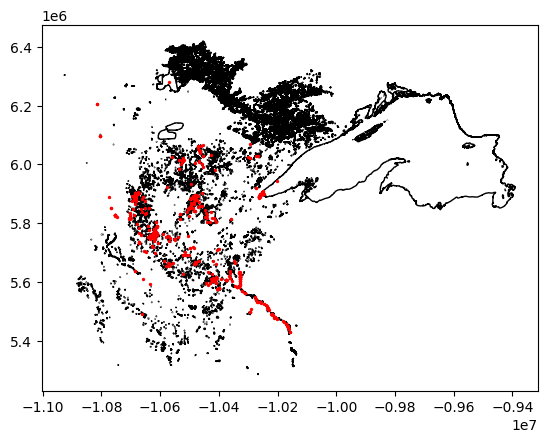

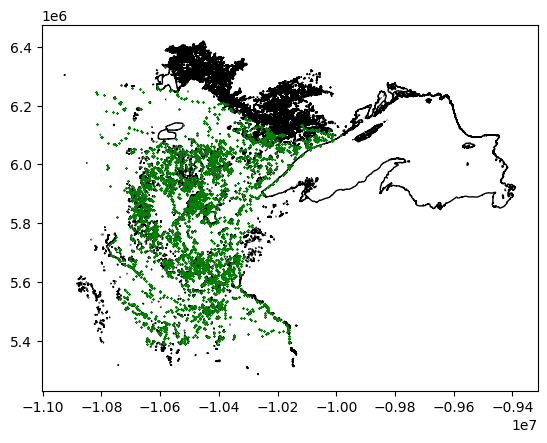

In [14]:
# Take a look at the data plots
base = lakes_gpd.plot(color = 'white', edgecolor = 'black')
my_data.plot(ax=base, marker='o', color='red', markersize=2)
base2 = lakes_gpd.plot(color = 'white', edgecolor = 'black')
my_accesses.plot(ax=base2, marker='x', color='green', markersize=1)


In [15]:
#Spatial join Points to polygons/ Need to do by nearest because boat ramps might not intersect lake polygon
#Use left join because we want to keep all the accesses and join them to the corresponding lake.
accesses_with_lakes = gpd.sjoin_nearest(my_accesses, lakes_gpd, 'left', max_distance = 100) 

C:\OSGeo4W\apps\Python39\lib\site-packages\pandas\core\reshape\merge.py:1112: RuntimeWarning: invalid value encountered in cast
  if not (lk == lk.astype(rk.dtype))[~np.isnan(lk)].all():


In [16]:
#Slice to what we need
# Rename the columns so we can group by right index (Lake_ID) Using the waterbody original index to groupby 
#ensures we aren't combining the count for ramps from lakes with same name.
accesses_with_lakes_df = pd.DataFrame(accesses_with_lakes[['FAC_NAME', 'index_right']]).rename(columns = {'FAC_NAME' : "ramps", 'index_right' : "lake_ID"})

In [17]:
# Groupby lake ID and count ramps per lake
ramps = pd.DataFrame(accesses_with_lakes_df.groupby(['lake_ID']).count())

In [18]:
# re-merge the ramps with the polygons 
ramps_df = gpd.GeoDataFrame(ramps.merge(lakes_gpd, left_index=True, right_index=True, how = 'right')).dropna()

In [19]:
# Join zm points to ramps layer
positive_lakes = gpd.sjoin_nearest(my_data, ramps_df, how='left')

In [41]:
# Remove duplicate lake records
positive_lakes2 = positive_lakes.drop_duplicates('index_right').rename(columns = {'index_right' : "lake_ID"})

In [42]:
# Slice to the columns we want
pos_lakes = positive_lakes2[['lake_ID', 'ramps']]

In [43]:
#create a list of the Lake IDs from positive lakes
positive_lake_IDs = pos_lakes['lake_ID']

In [44]:
# This is for merging on index to get negative lakes
ramps2 = pd.DataFrame(accesses_with_lakes_df.groupby(['lake_ID'], as_index=False).count())

In [45]:
# get lakes not in positive_lake_IDs list
neg_lakes = ramps2[~ramps2['lake_ID'].isin(positive_lake_IDs)]

#### Remove Outliers, add 1's and 0's, Check Out Summaries and Combine to Create Dataframes for Model Training/Testing.

In [46]:
# identify outliers with standard deviation
neg_outliers = neg_lakes.iloc[:,1].to_numpy().reshape(-1, 1)
# seed the random number generator
seed(1)
# generate univariate observations
neg_data = neg_outliers
# calculate summary statistics
neg_data_mean, neg_data_std = mean(neg_data), std(neg_data)
# identify outliers
neg_cut_off = neg_data_std * 5
neg_lower, neg_upper = neg_data_mean - neg_cut_off, neg_data_mean + neg_cut_off
# identify outliers
neg_outliers = [x for x in neg_data if x < neg_lower or x > neg_upper]
print('Identified outliers: %d' % len(neg_outliers))
# remove outliers
neg_outliers_removed = pd.DataFrame([x for x in neg_data if x >= neg_lower and x <= neg_upper])
print('Non-outlier observations: %d' % len(neg_outliers_removed))
neg_outliers_removed['Present'] = 0
neg_outliers_removed.describe()

Identified outliers: 7
Non-outlier observations: 1208


,0,Present
count,1208.000000,1208.0
mean,1.189570,0.0
std,0.557831,0.0
min,1.000000,0.0
25%,1.000000,0.0
50%,1.000000,0.0
75%,1.000000,0.0
max,5.000000,0.0


In [47]:
pos_outliers = pos_lakes.iloc[:,1].to_numpy().reshape(-1, 1)
# seed the random number generator
seed(1)
pos_data = pos_outliers
# calculate summary statistics
pos_data_mean, pos_data_std = mean(pos_data), std(pos_data)
# identify outliers
pos_cut_off = pos_data_std * 5
pos_lower, pos_upper = pos_data_mean - pos_cut_off, pos_data_mean + pos_cut_off
# identify outliers
pos_outliers = [x for x in pos_data if x < pos_lower or x > pos_upper]
print('Identified outliers: %d' % len(pos_outliers))
# remove outliers
pos_outliers_removed = pd.DataFrame([x for x in pos_data if x >= pos_lower and x <= pos_upper])
print('Non-outlier observations: %d' % len(pos_outliers_removed))
pos_outliers_removed['Present'] = 1
pos_outliers_removed.describe()

Identified outliers: 1
Non-outlier observations: 177


,0,Present
count,177.000000,177.0
mean,1.677966,1.0
std,1.531198,0.0
min,1.000000,1.0
25%,1.000000,1.0
50%,1.000000,1.0
75%,2.000000,1.0
max,13.000000,1.0


In [48]:
#Concatenate negative and positive dataframes.
training_data = pd.concat([neg_outliers_removed, pos_outliers_removed]).rename(columns = {0 : "ramps"})

In [49]:
#SLice to the columns we want and convert to numpy array 
my_model_data = training_data[['ramps', 'Present']].to_numpy()

In [50]:
#Use Scikit Learn function to split model data into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(
my_model_data[:,0].reshape(-1, 1), my_model_data[:,1], test_size=0.25, random_state=42)

#### Define and Fit the Logistic Regression Model

In [51]:
#Define Logistic Regression Model Variable
logr = LogisticRegression()

In [52]:
# Fit model to training data
logr.fit(x_train, y_train)

LogisticRegression()

## Results

When the positive and negative lake datasets are compared, the bias towards the number of negative lakes becomes apparent. When the means number of accesses per lake are compared between the treatments, it is evident that there is little difference between the treatments for the number of accesses per lake. The regression plot reflects what was inferred from comparing the means with no clear pattern between the number of accesses per lake and the presence of zebra mussels. 

Testing results are suspect with mostly 0's (absences) predicted and only three 1's (presence). Accuracy assessment for training/testing data shows ~90.0 %, but let's check the confusion matrix. Confusion matrix indicates 308 true negatives and 36 false negatives. 1 false positive and 2 true positives were predicted. The logistic regression coefficient (beta) is 1.87 indicating that for each additional access the probability of occurence of zebra mussels increases at this rate. However, when we consider the confusion matrix this is a bit "hand-wavy".

#### Model Outputs

<AxesSubplot:>

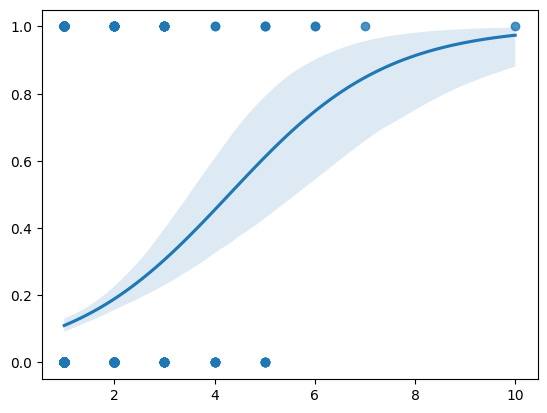

In [53]:
# Visualize regression plot.
sns.regplot(x=x_train, y=y_train, data= training_data, logistic=True)

In [54]:
# Predict to testing dataset
predictions = logr.predict(x_test)
predictions

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [55]:
# Check Accuracy Score when predicting test data
logr.score(x_test, y_test)

0.8933717579250721

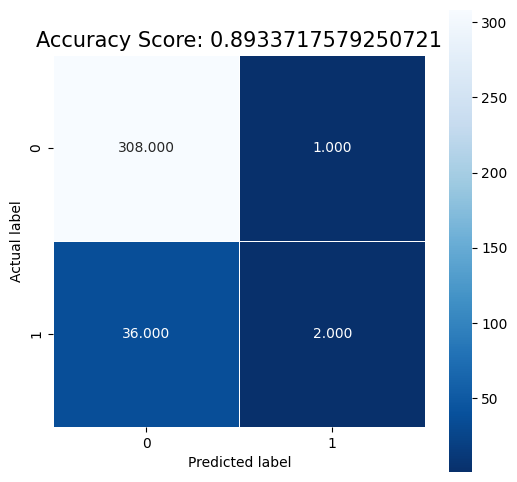

In [56]:
# Create Pretty Confusion Matrix
cm = metrics.confusion_matrix(y_test, predictions)
score = logr.score(x_test, y_test)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [57]:
# How does liklihood of invasion increase with an increase in ramps?
log_odds = logr.coef_
odds = np.exp(log_odds)
print(odds)

[[1.87371622]]


#### Use Model to Predict to Other Data

In [39]:
# create a random test array
my_test = np.arange(0.0, 27.0 , 1).reshape(-1, 1)

In [40]:
# Use model to predict test data
logr.predict_proba(my_test)

array([[9.34789598e-01, 6.52104022e-02],
       [8.94615591e-01, 1.05384409e-01],
       [8.34084536e-01, 1.65915464e-01],
       [7.48557426e-01, 2.51442574e-01],
       [6.38073017e-01, 3.61926983e-01],
       [5.10770128e-01, 4.89229872e-01],
       [3.82054763e-01, 6.17945237e-01],
       [2.68006785e-01, 7.31993215e-01],
       [1.78186606e-01, 8.21813394e-01],
       [1.13789418e-01, 8.86210582e-01],
       [7.06643925e-02, 9.29335607e-01],
       [4.30886478e-02, 9.56911352e-01],
       [2.59731832e-02, 9.74026817e-01],
       [1.55457933e-02, 9.84454207e-01],
       [9.26484272e-03, 9.90735157e-01],
       [5.50738131e-03, 9.94492619e-01],
       [3.26877294e-03, 9.96731227e-01],
       [1.93832757e-03, 9.98061672e-01],
       [1.14877165e-03, 9.98851228e-01],
       [6.80613125e-04, 9.99319387e-01],
       [4.03166079e-04, 9.99596834e-01],
       [2.38791301e-04, 9.99761209e-01],
       [1.41424255e-04, 9.99858576e-01],
       [8.37552531e-05, 9.99916245e-01],
       [4.960095

## Conclusions

The results indicate that my null hypothesis is not falsified. This could related to the dataset being heavilly biased with more records for lakes without zebra mussels.Though my hypothesis/prediction was not upheld, it is important to report these results because it shows that more than just public accesses is required to predict the presence/absence of zebra mussels. For example, watercraft visits should also be included to better capture the effect of the use of the accesses within the predictive model. Additionally, expanding the analysis to include other states may improve the model predictive ability. Despite not falsifying my null hypothesis, the code provided here can be modified to ask this question for additional NAS and for other states.  This makes the script here useful beyond the scope of this example analysis.

## References

Fuller P, Neilson M (2015) The U.S. Geological Survey’s Nonindigenous Aquatic Species Database: over thirty years of tracking introduced aquatic species in the United States (and counting). Management of Biological Invasions 6: 159–170. Available from: http://search.proquest.com/docview/2287069464/.

Johnson, L. E., Ricciardi, A., & Carlton, J. T. (2001). Overland dispersal of aquatic invasive species: a risk assessment of transient recreational boating. Ecological applications, 11(6), 1789-1799.

Nelson, N.M. (2019). Enumeration of potential economic costs of dreissenid mussels infestation in Montana. Universtiy of Montana http://dnrc.mt.gov/divisions/cardd/docs/misacdocs/dnrc_economic_cost_dreisseid_mussels_0119.pdf.

Pimentel D, Zuniga R, Morrison D (2005) Update on the environmental and economic costs associated with alien-invasive species in the United States. Ecological Economics 52: 273–288.

Sepulveda AJ, Nelson NM, Jerde CL, Luikart G (2020) Are Environmental DNA Methods Ready for Aquatic Invasive Species Management? Trends in Ecology & Evolution 35: 668–678. https://doi.org/https://doi.org/10.1016/j.tree.2020.03.011 

Wilson G, Aruliah DA, Brown CT, Chue Hong NP, Davis M, Guy RT, et al. (2014) Best Practices for Scientific Computing. PLoS Biol 12(1): e1001745. https://doi.org/10.1371/journal.pbio.1001745